<a href="https://colab.research.google.com/github/Hrithik2212/Regression-CNN---Facial-Key-Point-Detection/blob/main/00_Facial_Key_Point_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Key Point Detection with PyTorch
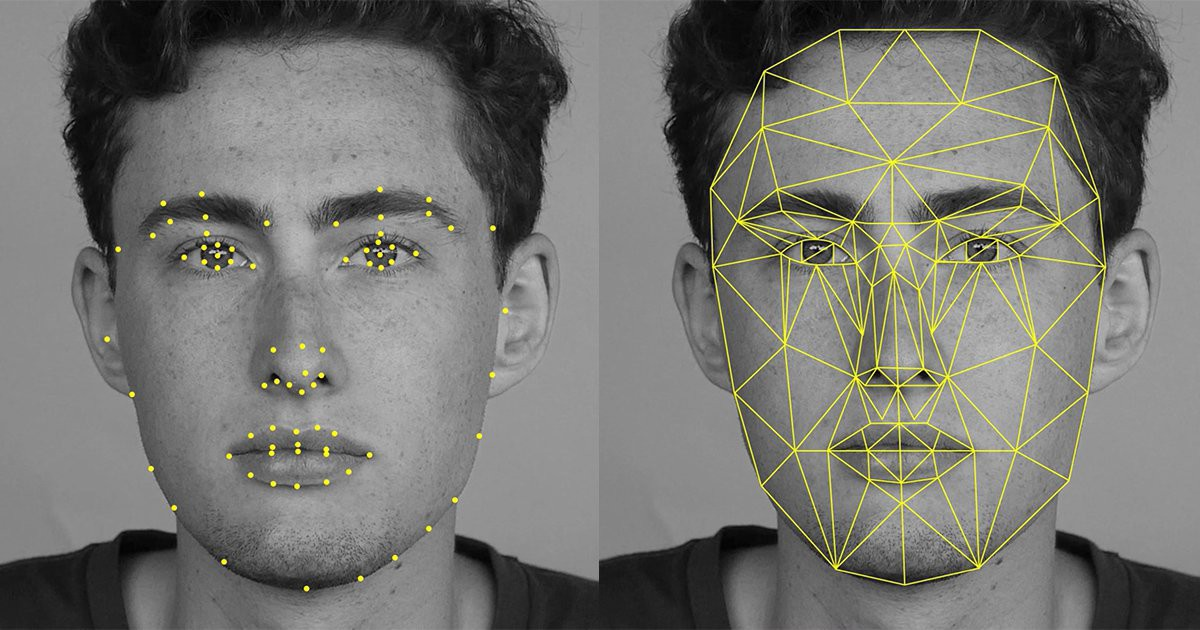

In [10]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
from PIL import Image 
from sklearn.model_selection import train_test_split

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Wrangling 


In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 1 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 16.45 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.


##  Data Exploration 

In [4]:
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Columns: 137 entries, Unnamed: 0 to 135
dtypes: float64(136), object(1)
memory usage: 3.6+ MB


In [6]:
data.shape

(3462, 137)

In [19]:
class FacesDataset:
  def __init__(self,df):
    super(FacesDataset).__init__
    self.df = df
    self.normalize = transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
  def __len__(self):
    return len(self.df)

  def __getitem__(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
        img = cv2.imread(img_path)/255.
        kp = deepcopy(self.df.iloc[ix,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2) 
        img = self.preprocess(img)
        return img, kp2
  
  def preprocess(self,img):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)
  
  def load_img(self, ix):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

In [22]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesDataset(train.reset_index(drop=True))
test_dataset = FacesDataset(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Model Building 

In [14]:
def get_model():
  model = models.vgg16(pretrained=True)
  for params in model.parameters():
    params.requires_grad=False
  model.avgpool = nn.Sequential(nn.Conv2d(512,512,3),
                                nn.MaxPool2d(2),
                                nn.Flatten())
  model.classifier = nn.Sequential(nn.Linear(2048,512),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(512,136),
                                   nn.Sigmoid())
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
  return model.to(device) , criterion , optimizer

model, criterion, optimizer = get_model()
summary(model,(3,224,224))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Training 

In [20]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss
@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

In [23]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" Epoch {epoch+ 1} out of 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item() 
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item() 
    epoch_test_loss /= (ix+1)
    print(f"Train Loss {epoch_train_loss} | Validation Loss {epoch_test_loss}")
    print(f"=====================================Done")
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

 Epoch 1 out of 50
Train Loss 0.05779689126487436 | Validation Loss 0.03407675171778961
=====================================Done
 Epoch 2 out of 50
Train Loss 0.040812438418125284 | Validation Loss 0.027055238542908974
=====================================Done
 Epoch 3 out of 50
Train Loss 0.034258490728064514 | Validation Loss 0.027872050350362606
=====================================Done
 Epoch 4 out of 50
Train Loss 0.030763170264404397 | Validation Loss 0.023610319010913372
=====================================Done
 Epoch 5 out of 50
Train Loss 0.028684502467513084 | Validation Loss 0.02347339935262095
=====================================Done
 Epoch 6 out of 50
Train Loss 0.027563773716489475 | Validation Loss 0.023920963602987202
=====================================Done
 Epoch 7 out of 50
Train Loss 0.026278851104193722 | Validation Loss 0.02143326714973558
=====================================Done
 Epoch 8 out of 50
Train Loss 0.024947233626554752 | Validation Loss 0.021658239

## Evaluation 

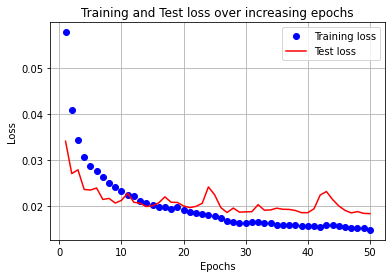

In [24]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

## Visualizing Results 

Index pos : 339


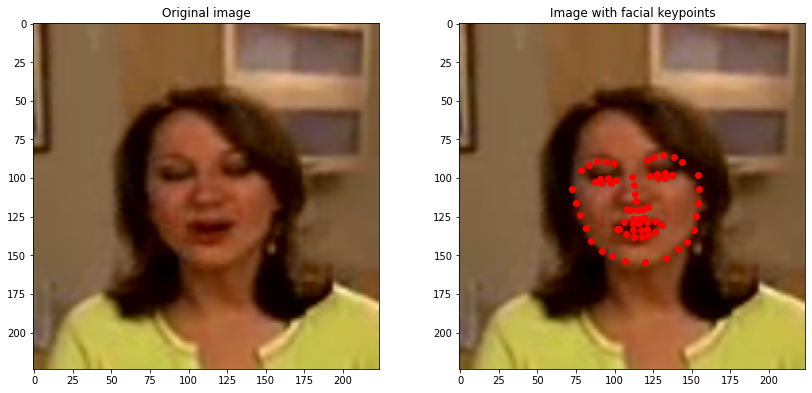

Index pos : 273


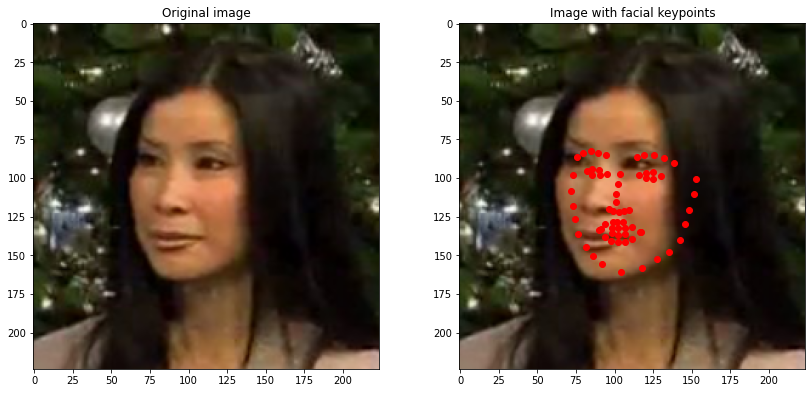

Index pos : 431


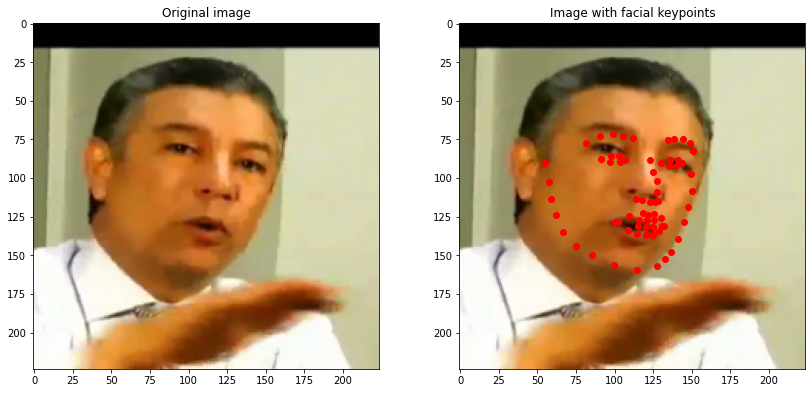

Index pos : 443


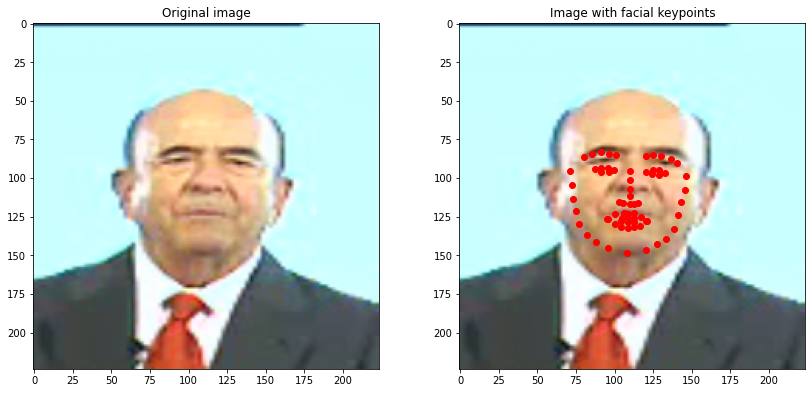

Index pos : 103


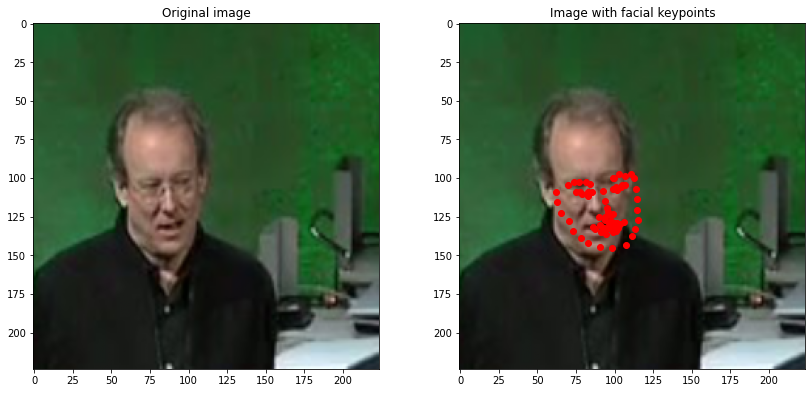

Index pos : 314


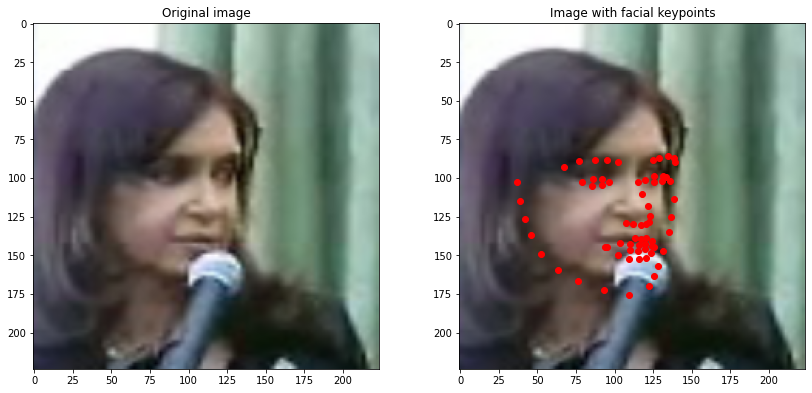

Index pos : 675


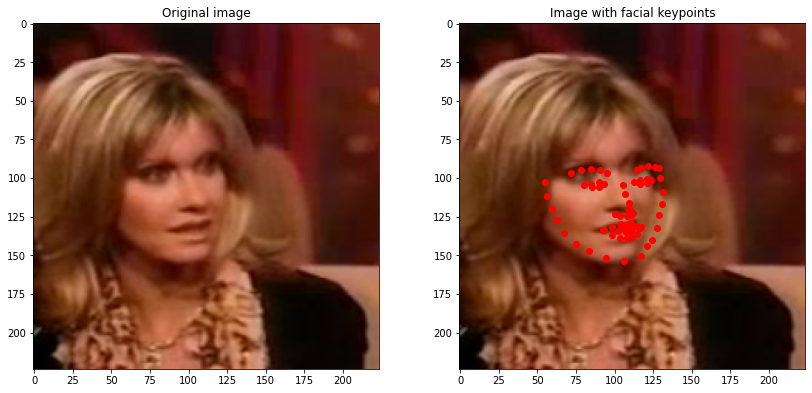

Index pos : 461


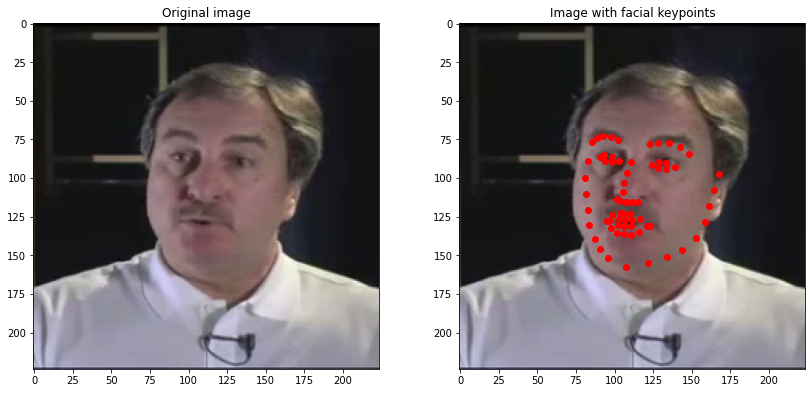

Index pos : 651


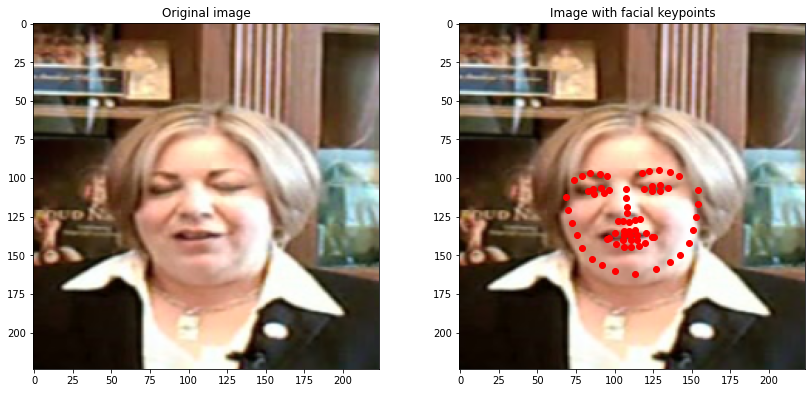

Index pos : 19


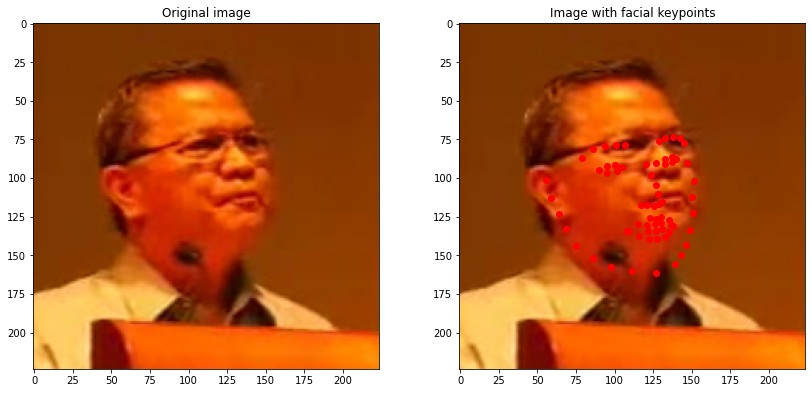

In [28]:
def plot_img(ix):
  plt.figure(figsize=(14,14))
  plt.subplot(221)
  plt.title('Original image')
  im = test_dataset.load_img(ix)
  plt.imshow(im)
  plt.grid(False)
  plt.subplot(222)
  plt.title('Image with facial keypoints')
  x, _ = test_dataset[ix]
  plt.imshow(im)
  kp = model(x[None]).flatten().detach().cpu()
  plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
  plt.grid(False)
  plt.show()
import random
for i in range(10):
  a = random.randint(0,len(test_dataset))
  print(f'Index pos : {a}')
  plot_img(a)